In [12]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from detection_utils import updatePoints, drawRoIPoly, applyLaneMasks
from detection_utils import save2File, loadFile, getLaneMask
from detection_utils import warped2BirdPoly, fitLaneLines, predictXVal
from detection_utils import getLanePoints, predictLaneLines
from detection_utils import measureCurveRadius, plotPredictionBoundry

%matplotlib inline

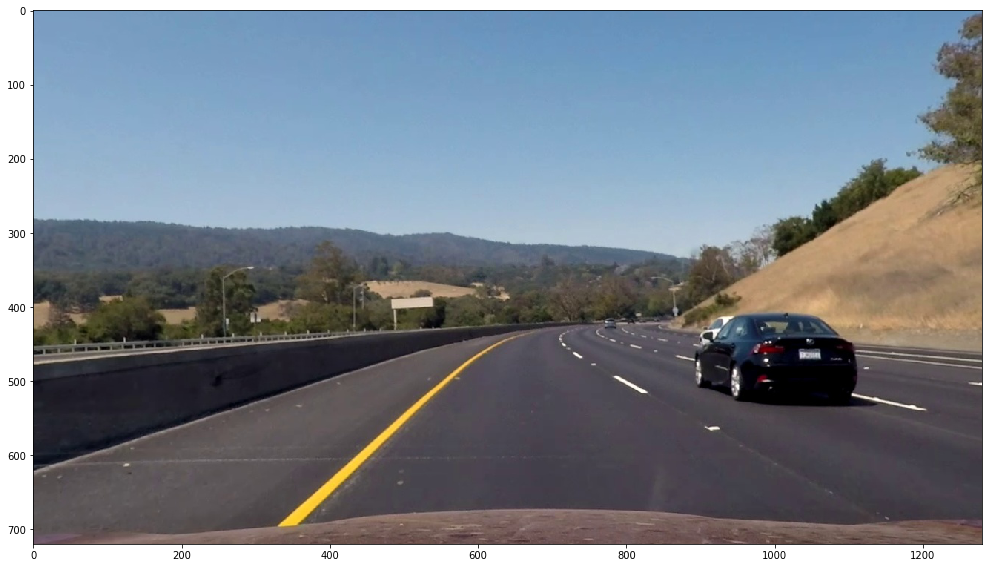

In [2]:
frame = plt.imread("./edge_thresh_calib/frame811.jpg")
plt.figure(figsize=(17, 17))
plt.imshow(frame)

In [44]:
# frame = plt.imread("./edge_thresh_calib/frame558.jpg")
camModel = loadFile("camCalibMatCoeffs")
camMtx = camModel["camMtx"]
dstCoeffs = camModel["dstCoeffs"]
frame = cv2.undistort(frame, camMtx, dstCoeffs, None, camMtx)
displayedFrame = frame.copy()
if os.path.exists("./roiPoly"):
    points = loadFile("./roiPoly")
if points is not None:
#     drawRoIPoly(displayedFrame, points)
    binaryLanes = getLaneMask(frame, 33, 200, 110, 30, 200)
    birdFrame, birdPoint = warped2BirdPoly(binaryLanes, points, 1280, 720)
    boutImg, leftLinePoints, rightLinePoints = getLanePoints(birdFrame, 11, 175, 55, )
    fitLaneLines(leftLinePoints, rightLinePoints, birdFrame.shape[0], 2)
    linesParams = loadFile("./linesFit")
    outImg, leftLine, rightLine = predictLaneLines(birdFrame, linesParams, margin=100)
    boundryMask, laneMask = plotPredictionBoundry(outImg, leftLine, rightLine, margin=100)
    M = cv2.getPerspectiveTransform(birdPoint, np.float32(points))
    boundryMask = cv2.warpPerspective(boundryMask, M, (1280, 720), cv2.INTER_LINEAR)
    laneMask = cv2.warpPerspective(laneMask, M, (1280, 720), cv2.INTER_LINEAR)
    displayedFrame = cv2.addWeighted(displayedFrame, 1, laneMask, 0.25, 0)
    displayedFrame = cv2.add(displayedFrame, boundryMask)
    
fig = plt.figure(figsize=(17, 7))
axis = fig.add_subplot(2, 3, 1)
axis.imshow(frame)
axis = fig.add_subplot(2, 3, 2)
axis.imshow(binaryLanes, "gray")
axis = fig.add_subplot(2, 3, 3)
axis.imshow(birdFrame, "gray")

axis = fig.add_subplot(2, 3, 4)
axis.imshow(boutImg)
axis = fig.add_subplot(2, 3, 5)
axis.imshow(outImg)
axis = fig.add_subplot(2, 3, 6)
axis.imshow(displayedFrame)

ValueError: not enough values to unpack (expected 3, got 2)

In [31]:
# def applyLaneMasks(srcFrame, birdPoint, roiPoints, *masks):
#     M = cv2.getPerspectiveTransform(birdPoint, np.float32(roiPoints))
#     boundryMask, laneMask = masks
#     boundryMask = cv2.warpPerspective(boundryMask, M, (1280, 720), cv2.INTER_LINEAR)
#     laneMask = cv2.warpPerspective(laneMask, M, (1280, 720), cv2.INTER_LINEAR)
#     displayedFrame = cv2.addWeighted(srcFrame, 1, laneMask, 0.25, 0)
#     displayedFrame = cv2.add(displayedFrame, boundryMask)
#     return displayedFrame
        

def getLaneWidthVariance(leftYPoints, rightYPoints, leftParams, rightParams):
    # approximate lane width
    leftUpperX = predictXVal(0, leftParams)
    rightUpperX = predictXVal(0, rightParams)
    leftBottomX = predictXVal(720, leftParams)
    rightBottomX = predictXVal(720, rightParams)
    dist1 = np.abs(rightUpperX - leftUpperX)
    dist2 = np.abs(rightBottomX - leftBottomX)
    distRange = np.abs(dist1 - dist2)
    return distRange
    

def getSlopeVariance(leftYPoints, rightYPoints, leftParams, rightParams):
    a, b , c = leftParams
    left_dxdy = a*leftYPoints + b 
    a, b , c = rightParams
    right_dxdy = a*leftYPoints + b
    slopeDiff = np.abs(right_dxdy - left_dxdy).mean()
    return slopeDiff


def linesInParallel(leftYPoints, rightYPoints, leftParams, rightParams, distThresh, slopeThresh):
    distRange = getLaneWidthVariance(leftYPoints, rightYPoints, leftParams, rightParams)
    slopeDifference = getSlopeVariance(leftYPoints, rightYPoints, leftParams, rightParams)
        
    distInRange = False if distRange > distThresh else True
    slopeInRange = False if slopeDifference > slopeThresh else True
    
    if distInRange and slopeInRange:
        return True
    return False


def paramsInRange(currLeftParams, currRightParams, prevLeftParams, prevRightParams):
    diff1 = currLeftParams - prevLeftParams
    diff2 = currRightParams - prevRightParams
#     print(diff1 - diff2)
    return False if ((diff1 - diff2) > 1.0).all() else True

function: getLaneMask, time to execute: 0.00715184211730957s
down
function: getLanePoints, time to execute: 0.020612239837646484s
function: fitLaneLines, time to execute: 0.0051670074462890625s
function: plotPredictionBoundry, time to execute: 0.004149675369262695s
function: applyLaneMasks, time to execute: 0.005326509475708008s
function: getLaneMask, time to execute: 0.008037090301513672s
down
function: getLanePoints, time to execute: 0.01805901527404785s
function: fitLaneLines, time to execute: 0.003422975540161133s
function: plotPredictionBoundry, time to execute: 0.002570629119873047s
function: applyLaneMasks, time to execute: 0.00553584098815918s
function: getLaneMask, time to execute: 0.005359649658203125s
down
function: getLanePoints, time to execute: 0.016080617904663086s
function: fitLaneLines, time to execute: 0.004200458526611328s
function: plotPredictionBoundry, time to execute: 0.0027582645416259766s
function: applyLaneMasks, time to execute: 0.006524324417114258s
function

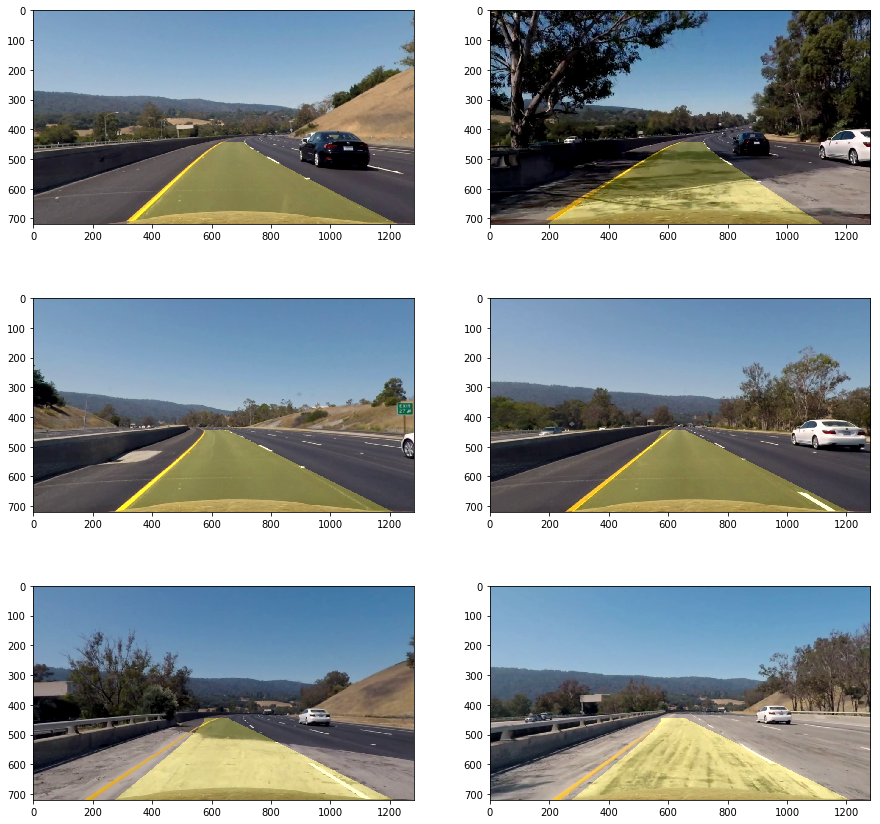

In [13]:
allRightParams = []
allLeftParams = []
fig = plt.figure(figsize=(15, 15))
images = glob("./edge_thresh_calib/*.jpg")
for i, imgPath in enumerate(images):
    frame = plt.imread(imgPath)
    camModel = loadFile("camCalibMatCoeffs")
    camMtx = camModel["camMtx"]
    dstCoeffs = camModel["dstCoeffs"]
    frame = cv2.undistort(frame, camMtx, dstCoeffs, None, camMtx)
    displayedFrame = frame.copy()
    if os.path.exists("./roiPoly"):
        points = loadFile("./roiPoly")
    if points is not None:
#         binaryLanes = getLaneMask(frame, 33, 200, 110, 30, 165)
        binaryLanes = getLaneMask(frame, 33, 175, 110, 30, 170)
        birdFrame, birdPoint = warped2BirdPoly(binaryLanes, points, 1280, 720)
        if allLeftParams and allRightParams and i > 2:
            print("up")
            linesParams = np.mean(allLeftParams[-3::], axis=0), np.mean(allRightParams[-3::], axis=0)
            linesParams, leftLine, rightLine = predictLaneLines(birdFrame, linesParams, margin=100)
        else:
            print("down")
            leftLanePoints, rightLanePoints = getLanePoints(birdFrame, 11, 175, 55, )
            linesParams, leftLinePoints, rightLinePoints = fitLaneLines(
                leftLanePoints, rightLanePoints, birdFrame.shape[0], order=2
            )    
        allLeftParams.append(linesParams[0])
        allRightParams.append(linesParams[1])
        laneMask = plotPredictionBoundry(birdFrame, leftLinePoints, rightLinePoints, margin=100)
        displayedFrame = applyLaneMasks(displayedFrame, birdPoint, points, laneMask)
#         print(evalLaneDetection(leftLinePoints[1][350:], rightLinePoints[1][350:], **linesParams))
#         print(compareWithLastDetection(linesParams["leftParams"], linesParams["rightParams"], allLeftParams[-1], allRightParams[-1]))
        axis = fig.add_subplot(len(images)//2, 2, i+1)
        axis.imshow(displayedFrame)
    

In [14]:
allRightParams = []
allLeftParams = []
fig = plt.figure(figsize=(15, 15))
images = glob("./edge_thresh_calib/*.jpg")
for i, imgPath in enumerate(images):
    frame = plt.imread(imgPath)
    camModel = loadFile("camCalibMatCoeffs")
    camMtx = camModel["camMtx"]
    dstCoeffs = camModel["dstCoeffs"]
    frame = cv2.undistort(frame, camMtx, dstCoeffs, None, camMtx)
    displayedFrame = frame.copy()
    if os.path.exists("./roiPoly"):
        points = loadFile("./roiPoly")
    if points is not None:
#         binaryLanes = getLaneMask(frame, 33, 200, 110, 30, 165)
        binaryLanes = getLaneMask(frame, 33, 175, 110, 30, 170)
        birdFrame, birdPoint = warped2BirdPoly(binaryLanes, points, 1280, 720)
        if allLeftParams and allRightParams and i > 2:
            print("up")
            linesParams = np.mean(allLeftParams[-3::], axis=0), np.mean(allRightParams[-3::], axis=0)
            linesParams, leftLine, rightLine = predictLaneLines(birdFrame, linesParams, margin=100)
        else:
            print("down")
            leftLanePoints, rightLanePoints = getLanePoints(birdFrame, 11, 175, 55, )
            linesParams, leftLinePoints, rightLinePoints = fitLaneLines(
                leftLanePoints, rightLanePoints, birdFrame.shape[0], order=2
            )    
        allLeftParams.append(linesParams[0])
        allRightParams.append(linesParams[1])
        boundryMask, laneMask = plotPredictionBoundry(birdFrame, leftLinePoints, rightLinePoints, margin=100)
        displayedFrame = applyLaneMasks(displayedFrame, birdPoint, points, boundryMask, laneMask)
#         print(evalLaneDetection(leftLinePoints[1][350:], rightLinePoints[1][350:], **linesParams))
#         print(compareWithLastDetection(linesParams["leftParams"], linesParams["rightParams"], allLeftParams[-1], allRightParams[-1]))
        axis = fig.add_subplot(len(images)//2, 2, i+1)
        axis.imshow(displayedFrame)
    

function: getLaneMask, time to execute: 0.008429765701293945s
down
function: getLanePoints, time to execute: 0.018784046173095703s
function: fitLaneLines, time to execute: 0.05062437057495117s
function: plotPredictionBoundry, time to execute: 0.004869937896728516s


ValueError: too many values to unpack (expected 2)

<Figure size 1080x1080 with 0 Axes>

function: getLaneMask, time to execute: 0.006606578826904297s
down
function: getLanePoints, time to execute: 0.01646900177001953s
function: fitLaneLines, time to execute: 0.0036733150482177734s
function: plotPredictionBoundry, time to execute: 0.002799510955810547s
function: applyLaneMasks, time to execute: 0.00446772575378418s
function: getLaneMask, time to execute: 0.011815309524536133s
up
function: fitLaneLines, time to execute: 0.003754138946533203s
function: plotPredictionBoundry, time to execute: 0.0024619102478027344s
function: applyLaneMasks, time to execute: 0.005791664123535156s
function: getLaneMask, time to execute: 0.0059354305267333984s
up
function: fitLaneLines, time to execute: 0.00167083740234375s
function: plotPredictionBoundry, time to execute: 0.0033271312713623047s
function: applyLaneMasks, time to execute: 0.006515026092529297s
function: getLaneMask, time to execute: 0.007318735122680664s
up
function: fitLaneLines, time to execute: 0.0018589496612548828s
function:

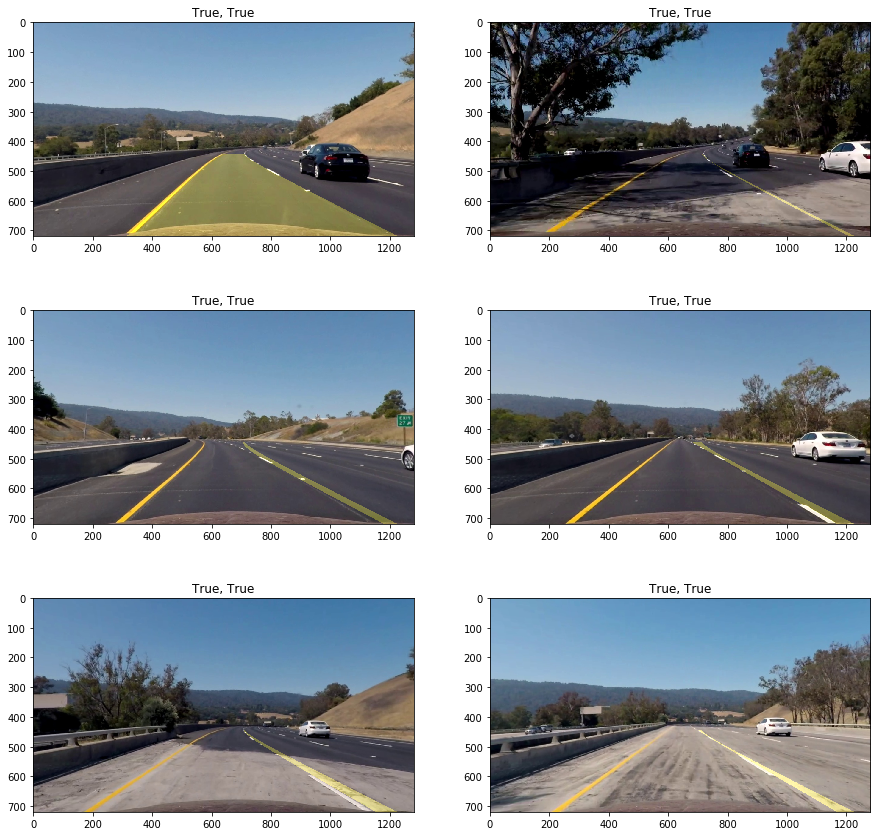

In [35]:
allRightParams = []
allLeftParams = []
goodFit = False
isParallel = False

fig = plt.figure(figsize=(15, 15))
images = glob("./edge_thresh_calib/*.jpg")
for i, imgPath in enumerate(images):
    frame = plt.imread(imgPath)
    camModel = loadFile("camCalibMatCoeffs")
    camMtx = camModel["camMtx"]
    dstCoeffs = camModel["dstCoeffs"]
    frame = cv2.undistort(frame, camMtx, dstCoeffs, None, camMtx)
    displayedFrame = frame.copy()
    if os.path.exists("./roiPoly"):
        points = loadFile("./roiPoly")
    if points is not None:
#         binaryLanes = getLaneMask(frame, 33, 200, 110, 30, 165)
        binaryLanes = getLaneMask(frame, 33, 175, 110, 30, 170)
        birdFrame, birdPoint = warped2BirdPoly(binaryLanes, points, 1280, 720)
        if allLeftParams and allRightParams:
            if goodFit and isParallel:
                print("up")
                linesParams = np.mean(allLeftParams[-3::], axis=0), np.mean(allRightParams[-3::], axis=0)
                linesParams, leftLinePoints, leftLinePoints = predictLaneLines(birdFrame, linesParams, margin=100)
        else:
            print("down")
            leftLanePoints, rightLanePoints = getLanePoints(birdFrame, 11, 175, 55, )
            linesParams, leftLinePoints, rightLinePoints = fitLaneLines(
                leftLanePoints, rightLanePoints, birdFrame.shape[0], order=2
            )    
        allLeftParams.append(linesParams[0])
        allRightParams.append(linesParams[1])
        laneMask = plotPredictionBoundry(birdFrame, leftLinePoints, rightLinePoints, margin=100)
        displayedFrame = applyLaneMasks(displayedFrame, birdPoint, points, laneMask)
        currLeftParams, currRightParams = linesParams
        prevLeftParams, prevRightParams = allLeftParams[-1], allRightParams[-1]
        goodFit = paramsInRange(currLeftParams, currRightParams, prevLeftParams, prevRightParams)
        isParallel = linesInParallel(leftLinePoints[1][330:], leftLinePoints[1][330:], *linesParams, 155, 1)

        axis = fig.add_subplot(len(images)//2, 2, i+1)
        axis.set_title(f"{goodFit}, {isParallel}")
        axis.imshow(displayedFrame)
    

In [30]:
import pandas as pd
import numpy as np


X = np.random.randint(0, 15, size=(15, 1))
df = pd.DataFrame(X, columns=["family"])
df["family"][5: 9] = 0 
df["have_family"] = 0
df

,family,have_family
0,13,0
1,12,0
2,12,0
3,8,0
4,5,0
5,0,0
6,0,0
7,0,0
8,0,0
9,9,0


In [34]:
idxs = df["family"] > 0
idxs

0      True
1      True
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9      True
10     True
11     True
12     True
13     True
14    False
Name: family, dtype: bool

In [32]:
df["have_family"][idxs] = 1

In [33]:
df

,family,have_family
0,13,1
1,12,1
2,12,1
3,8,1
4,5,1
5,0,0
6,0,0
7,0,0
8,0,0
9,9,1
